In [5]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype
import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import colors

In [8]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df["lat_x"].max() + 1
    latS = df["lat_x"].min() - 1
    lonW = df["lon_x"].max() + 1
    lonE = df["lon_x"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=600
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon_x"],
        y=df["lat_x"],
        c=df["color"],
        s=100,
        edgecolor="black",
        marker="o",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Proposed Mesonet Site Clusters; n = 8", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.grid()
    ax.legend(
        bbox_to_anchor=(1.05, 1),
        loc="best",
        borderaxespad=0,
        handles=patches,
        fontsize="x-large",
    )

In [9]:
def stackbar_df(df):
    statlist = []
    div_list1 = []
    div_list2 = []
    div_list3 = []
    div_list4 = []
    class1_list = []
    class2_list = []
    class3_list = []

    for x, _ in enumerate(df["station"]):
        station = df["station"].iloc[x]
        divide1 = (df["firstmode_count"].iloc[x] / df["sum_total"].iloc[x]) * 100
        class1 = df["firstmode_val"].iloc[x]
        divide2 = (df["secondmode_count"].iloc[x] / df["sum_total"].iloc[x]) * 100
        class2 = df["secondmode_val"].iloc[x]
        divide3 = (df["thirdmode_count"].iloc[x] / df["sum_total"].iloc[x]) * 100
        class3 = df["thirdmode_val"].iloc[x]
        divide4 = 100 - (divide1 + divide2 + divide3)
        statlist.append(station)
        div_list1.append(divide1)
        div_list2.append(divide2)
        div_list3.append(divide3)
        div_list4.append(divide4)
        class1_list.append(class1)
        class2_list.append(class2)
        class3_list.append(class3)

    stackbar_df = pd.DataFrame()
    stackbar_df["station"] = statlist
    stackbar_df["div1"] = div_list1
    stackbar_df["div2"] = div_list2
    stackbar_df["div3"] = div_list3
    stackbar_df["div4"] = div_list4
    stackbar_df["class1"] = class1_list
    stackbar_df["class2"] = class2_list
    stackbar_df["class3"] = class3_list

    # add appropriate colors
    # get colors
    colors = [
        "black",
        "blue",
        "white",
        "coral",
        "pink",
        "red",
        "magenta",
        "gray",
        "lime",
        "forestgreen",
        "green",
        "olive",
        "brown",
        "slategray",
        "darkorchid",
        "plum",
        "indigo",
        "purple",
        "yellow",
        "gold",
        "orange",
        "cyan",
    ]
    legend = np.array(
        [
            0,
            11,
            12,
            21,
            22,
            23,
            24,
            31,
            41,
            42,
            43,
            45,
            51,
            52,
            71,
            72,
            73,
            74,
            81,
            82,
            90,
            95,
        ]
    )
    leg_str = [
        "No Data",
        "Open Water",
        "Perennial Ice/Snow",
        "Developed, Open Space",
        "Developed, Low Intensity",
        "Developed, Medium Intensity",
        "Developed High Intensity",
        "Barren Land (Rock/Sand/Clay)",
        "Deciduous Forest",
        "Evergreen Forest",
        "Mixed Forest",
        "Forest/Shrub",
        "Dwarf Scrub",
        "Shrub/Scrub",
        "Grassland/Herbaceous",
        "Sedge/Herbaceous",
        "Lichens",
        "Moss",
        "Pasture/Hay",
        "Cultivated Crops",
        "Woody Wetlands",
        "Emergent Herbaceous Wetlands",
    ]

    descripdict = {}
    colordict = {}

    for x, _ in enumerate(colors):
        descripdict.update({legend[x]: leg_str[x]})
        colordict.update({legend[x]: colors[x]})

    stackbar_df["color1"] = stackbar_df["class1"].map(colordict)
    stackbar_df["color2"] = stackbar_df["class2"].map(colordict)
    stackbar_df["color3"] = stackbar_df["class3"].map(colordict)
    stackbar_df["color4"] = "black"

    return stackbar_df

In [10]:
def stackplot(df):
    colors = [
        "black",
        "blue",
        "white",
        "coral",
        "pink",
        "red",
        "magenta",
        "gray",
        "lime",
        "forestgreen",
        "green",
        "olive",
        "brown",
        "slategray",
        "darkorchid",
        "plum",
        "indigo",
        "purple",
        "yellow",
        "gold",
        "orange",
        "cyan",
    ]
    legend = np.array(
        [
            0,
            11,
            12,
            21,
            22,
            23,
            24,
            31,
            41,
            42,
            43,
            45,
            51,
            52,
            71,
            72,
            73,
            74,
            81,
            82,
            90,
            95,
        ]
    )
    leg_str = [
        "No Data",
        "Open Water",
        "Perennial Ice/Snow",
        "Developed, Open Space",
        "Developed, Low Intensity",
        "Developed, Medium Intensity",
        "Developed High Intensity",
        "Barren Land (Rock/Sand/Clay)",
        "Deciduous Forest",
        "Evergreen Forest",
        "Mixed Forest",
        "Forest/Shrub",
        "Dwarf Scrub",
        "Shrub/Scrub",
        "Grassland/Herbaceous",
        "Sedge/Herbaceous",
        "Lichens",
        "Moss",
        "Pasture/Hay",
        "Cultivated Crops",
        "Woody Wetlands",
        "Emergent Herbaceous Wetlands",
    ]

    # legend
    patches = []
    for i, _ in enumerate(colors):
        patch = mpatches.Patch(color=colors[i], label=leg_str[i])
        patches.append(patch)
    fig, ax = plt.subplots(figsize=(20, 20), dpi=600)
    ax.set_xlabel("Mesonet Sites")
    ax.set_ylabel("Percet of Total By Landtype")
    ax.set_title("Cluster Plot")

    df = df.sort_values(by=["color1"], ascending=True)
    for x, _ in enumerate(df["station"]):
        h1 = df["div1"].iloc[x]
        h2 = h1 + df["div2"].iloc[x]
        h3 = h2 + df["div3"].iloc[x]
        h4 = h3 + df["div4"].iloc[x]
        ax.bar(x=x, height=h4, color=df["color1"].iloc[x])
        ax.bar(x=x, height=h3, color=df["color2"].iloc[x])
        ax.bar(x=x, height=h2, color=df["color3"].iloc[x])
        ax.bar(x=x, height=h1, color=df["color4"].iloc[x])
        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc="best",
            borderaxespad=0,
            handles=patches,
            fontsize="xx-large",
        )

In [11]:
def elev_plot(df):
    fig = plt.figure(figsize=(12, 12), dpi=600)
    ax = fig.add_subplot(projection="3d")
    length = len(df["station"])
    xs = range(0, length)
    ys = df["elev"]
    zs1 = df["std"]
    zs2 = df["skew"]
    zs3 = df["med_dist"]
    ax.scatter(xs, ys, zs1, s=70, marker="x", color="r", label="std")
    ax.scatter(xs, ys, zs3, s=70, marker="v", color="g", label="med_dist")
    ax.set_xlabel("Station")
    ax.set_ylabel("Elevation")
    ax.set_zlabel("Variables")
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.legend()
    ax.view_init(15, 30)
    plt.show()

In [12]:
def get_stations(df):
    station_ls = []
    for x, _ in enumerate(df["station"]):
        station = df["station"].iloc[x]
        station_ls.append(station)
    return station_ls

In [13]:
def slope_plot(df):
    fig, ax = plt.subplots(figsize=(20, 20), dpi=600)
    ax = fig.add_subplot(projection="3d")
    ax.view_init(15, 45)
    ax.set_xlabel("Mesonet Sites")
    ax.set_ylabel("Aspect Slope Class")
    ax.set_zlabel("Count")
    ax.set_title("New York")
    station_ls = get_stations(df)
    for i, _ in enumerate(station_ls):
        df = pd.read_csv(
            f"/home/aevans/landtype/elevation/data/NY/slope/30km/{station_ls[i]}_slope_30km.csv"
        )
        for x, _ in df.iterrows():
            dfv = df.iloc[x]
            classt = dfv[2]
            count_ = dfv[3]
            if classt != 19:
                top = count_
                bottom = np.zeros_like(top)
                width = depth = 1
                ax.bar3d(i, classt, bottom, width, depth, top, shade=True)

In [14]:
def slope_plot_ok(df):
    fig, ax = plt.subplots(figsize=(20, 20), dpi=600)
    ax = fig.add_subplot(projection="3d")
    ax.view_init(15, 45)
    ax.set_xlabel("Mesonet Sites")
    ax.set_ylabel("Aspect Slope Class")
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_zlabel("Count")
    ax.set_title("Slopes")
    station_ls = get_stations(df)
    for i, _ in enumerate(station_ls):
        df = pd.read_csv(
            f"/home/aevans/landtype/elevation/data/OK/slope/30km/{station_ls[i]}_slope_30km.csv"
        )
        for x, _ in df.iterrows():
            dfv = df.iloc[x]
            classt = dfv[2]
            count_ = dfv[3]
            if classt != 19:
                top = count_
                bottom = np.zeros_like(top)
                width = depth = 1
                ax.bar3d(i, classt, bottom, width, depth, top, shade=True)

In [15]:
colors = ["black", "blue", "coral", "pink", "red", "magenta", "gray", "lime"]

cats = [
    "Plateau",
    "Great Lakes",
    "ADK East",
    "Elevated",
    "Urban",
    "Catskills",
    "Valley",
    "ADK West",
]

legend = [0, 1, 2, 3, 4, 5, 6, 7]

descripdict = {}
colordict = {}

for x, _ in enumerate(colors):
    descripdict.update({legend[x]: cats[x]})
    colordict.update({legend[x]: colors[x]})

In [17]:
df_cats = pd.read_csv("/home/aevans/nwp_bias/src/landtype/src/df_new_cats.csv").drop(
    columns=[
        "Unnamed: 0.1",
        "Unnamed: 0",
        "site_x",
        "11",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "lon_y",
        "lat_y",
        "site_y",
        "19",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "35",
        "36",
        "Unnamed: 0_y",
    ]
)

In [18]:
df_cats["color"] = df_cats["Cluster"].map(colordict)
df_cats["cat"] = df_cats["Cluster"].map(descripdict)

In [19]:
patches = []
for i, _ in enumerate(colors):
    patch = mpatches.Patch(color=colors[i], label=cats[i])
    patches.append(patch)

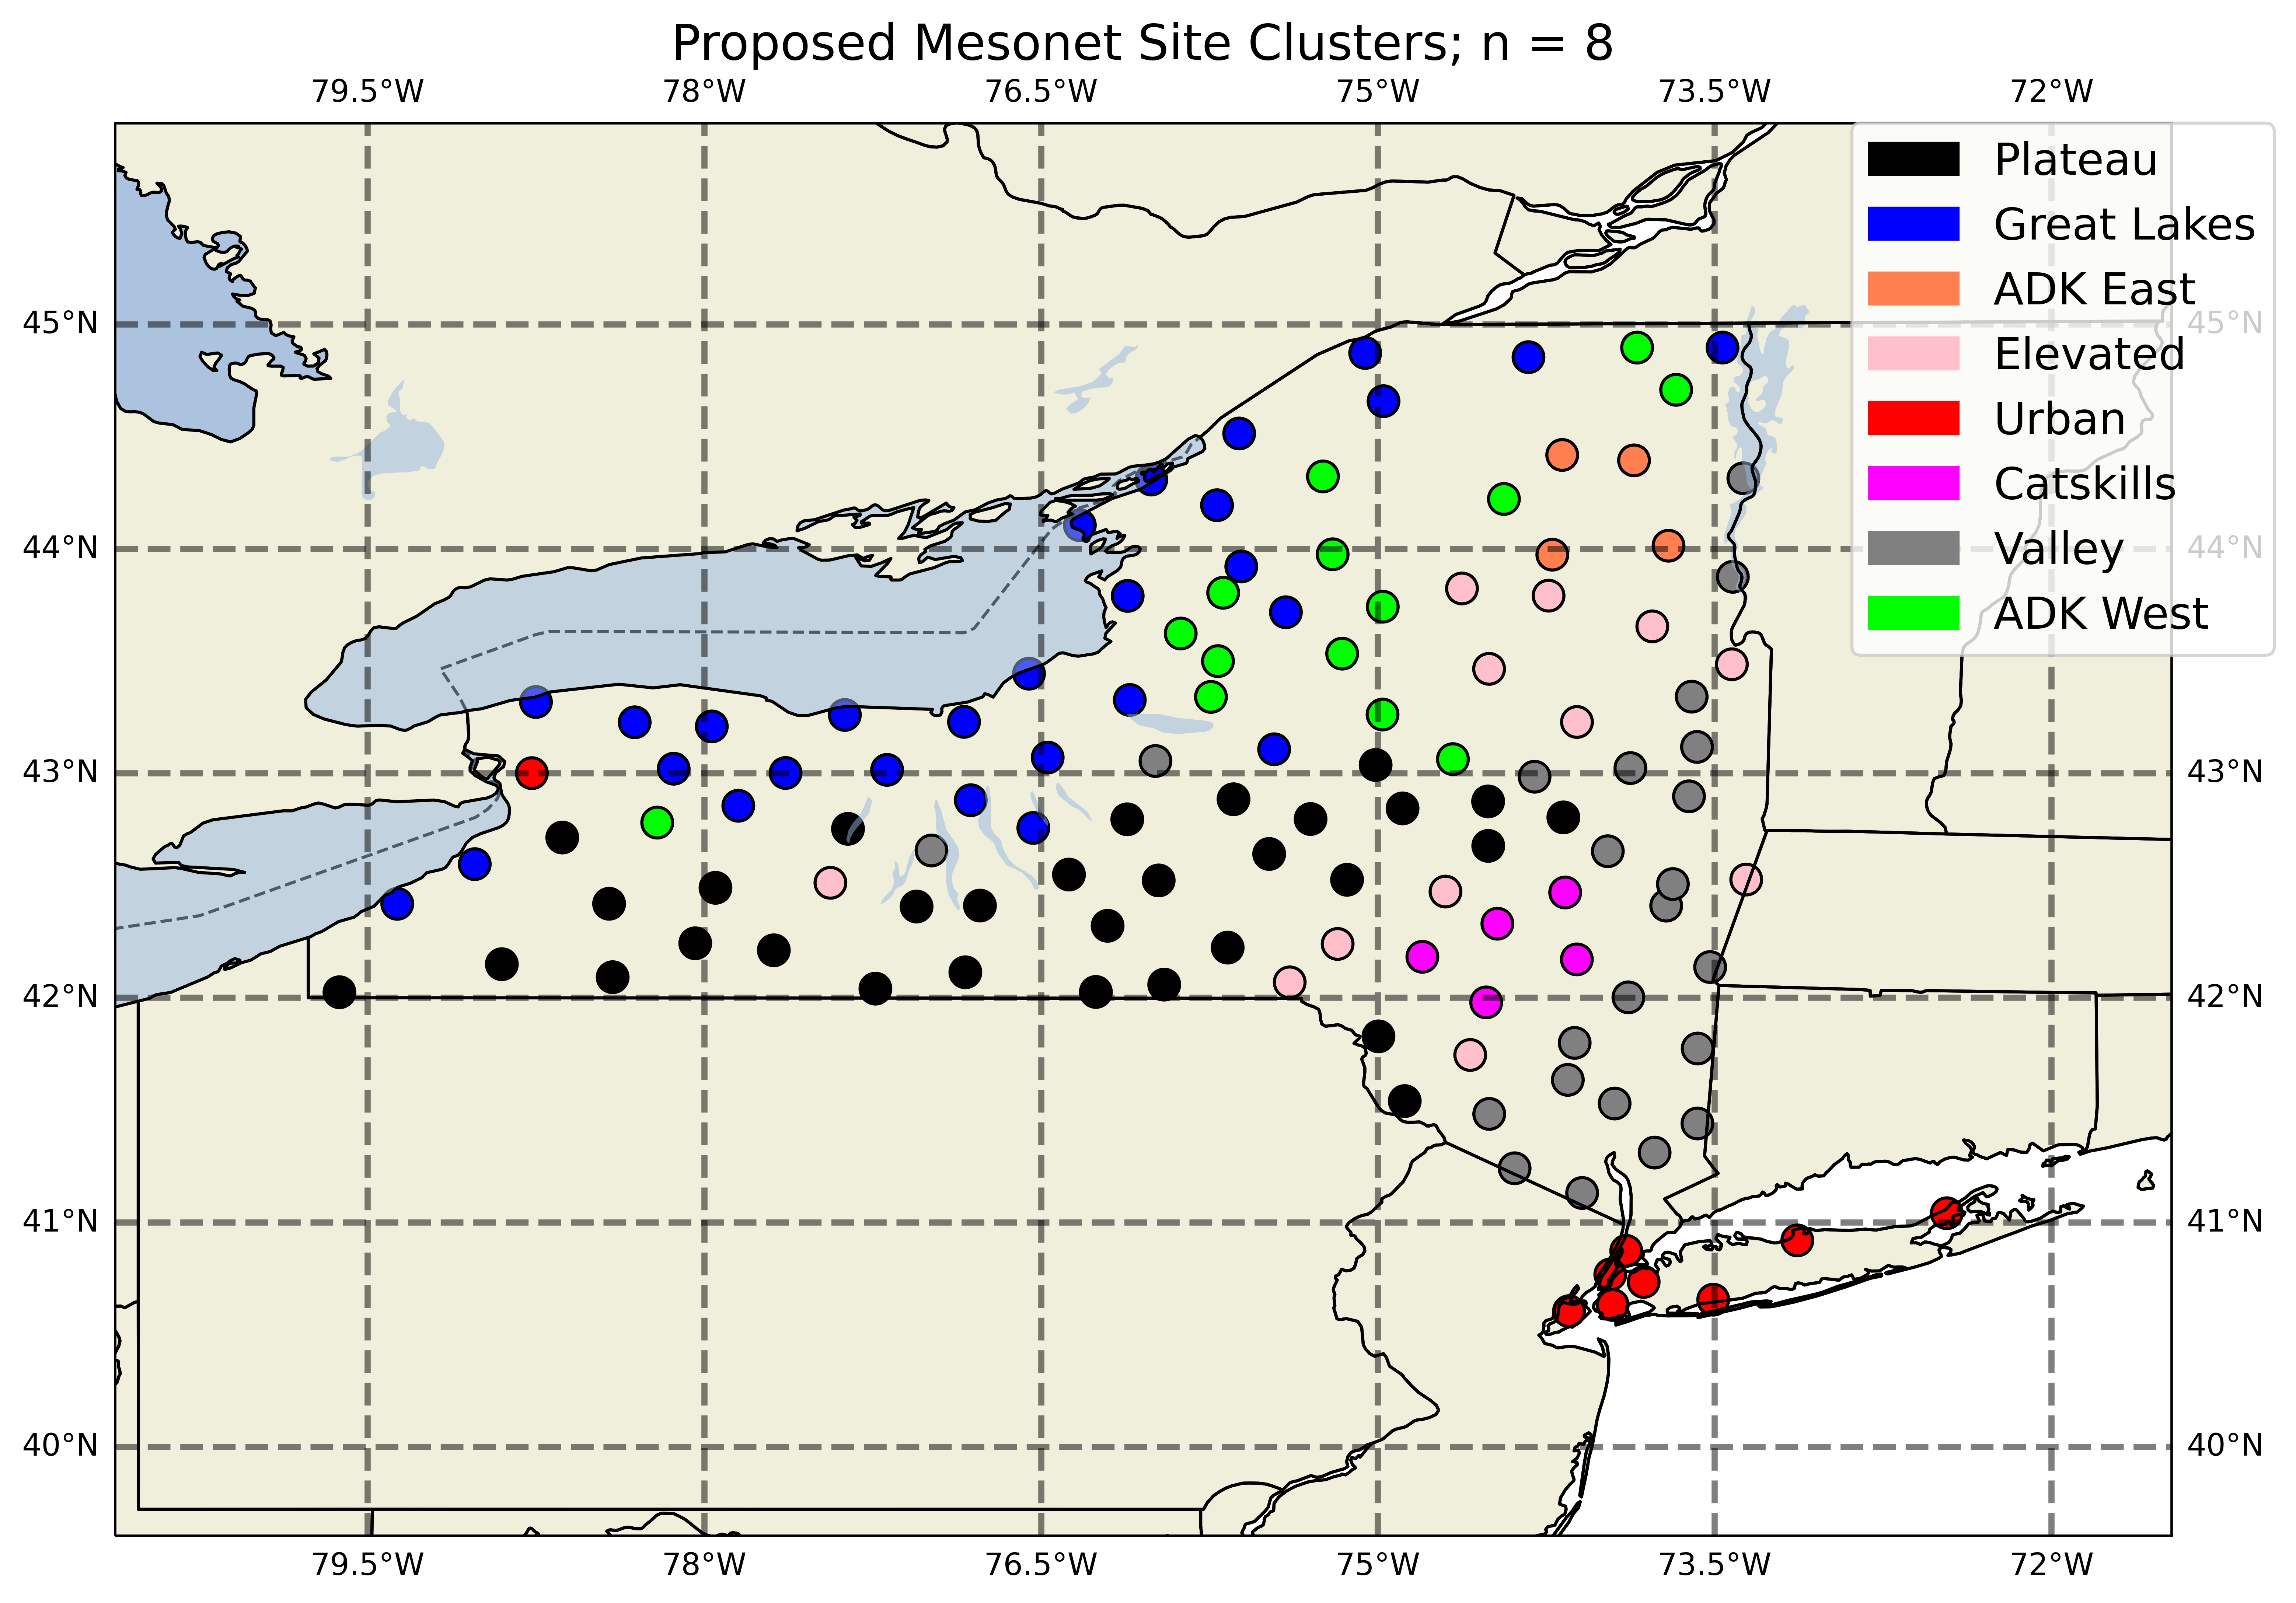

In [20]:
plurality_plot(df_cats)

In [21]:
convert_dict = {"div1": int, "div2": int, "div3": int, "div4": int}

In [22]:
# cluster 0
cluster_0 = df_cats.where(df_cats["Cluster"] == 0).dropna()
stack_df = stackbar_df(cluster_0)

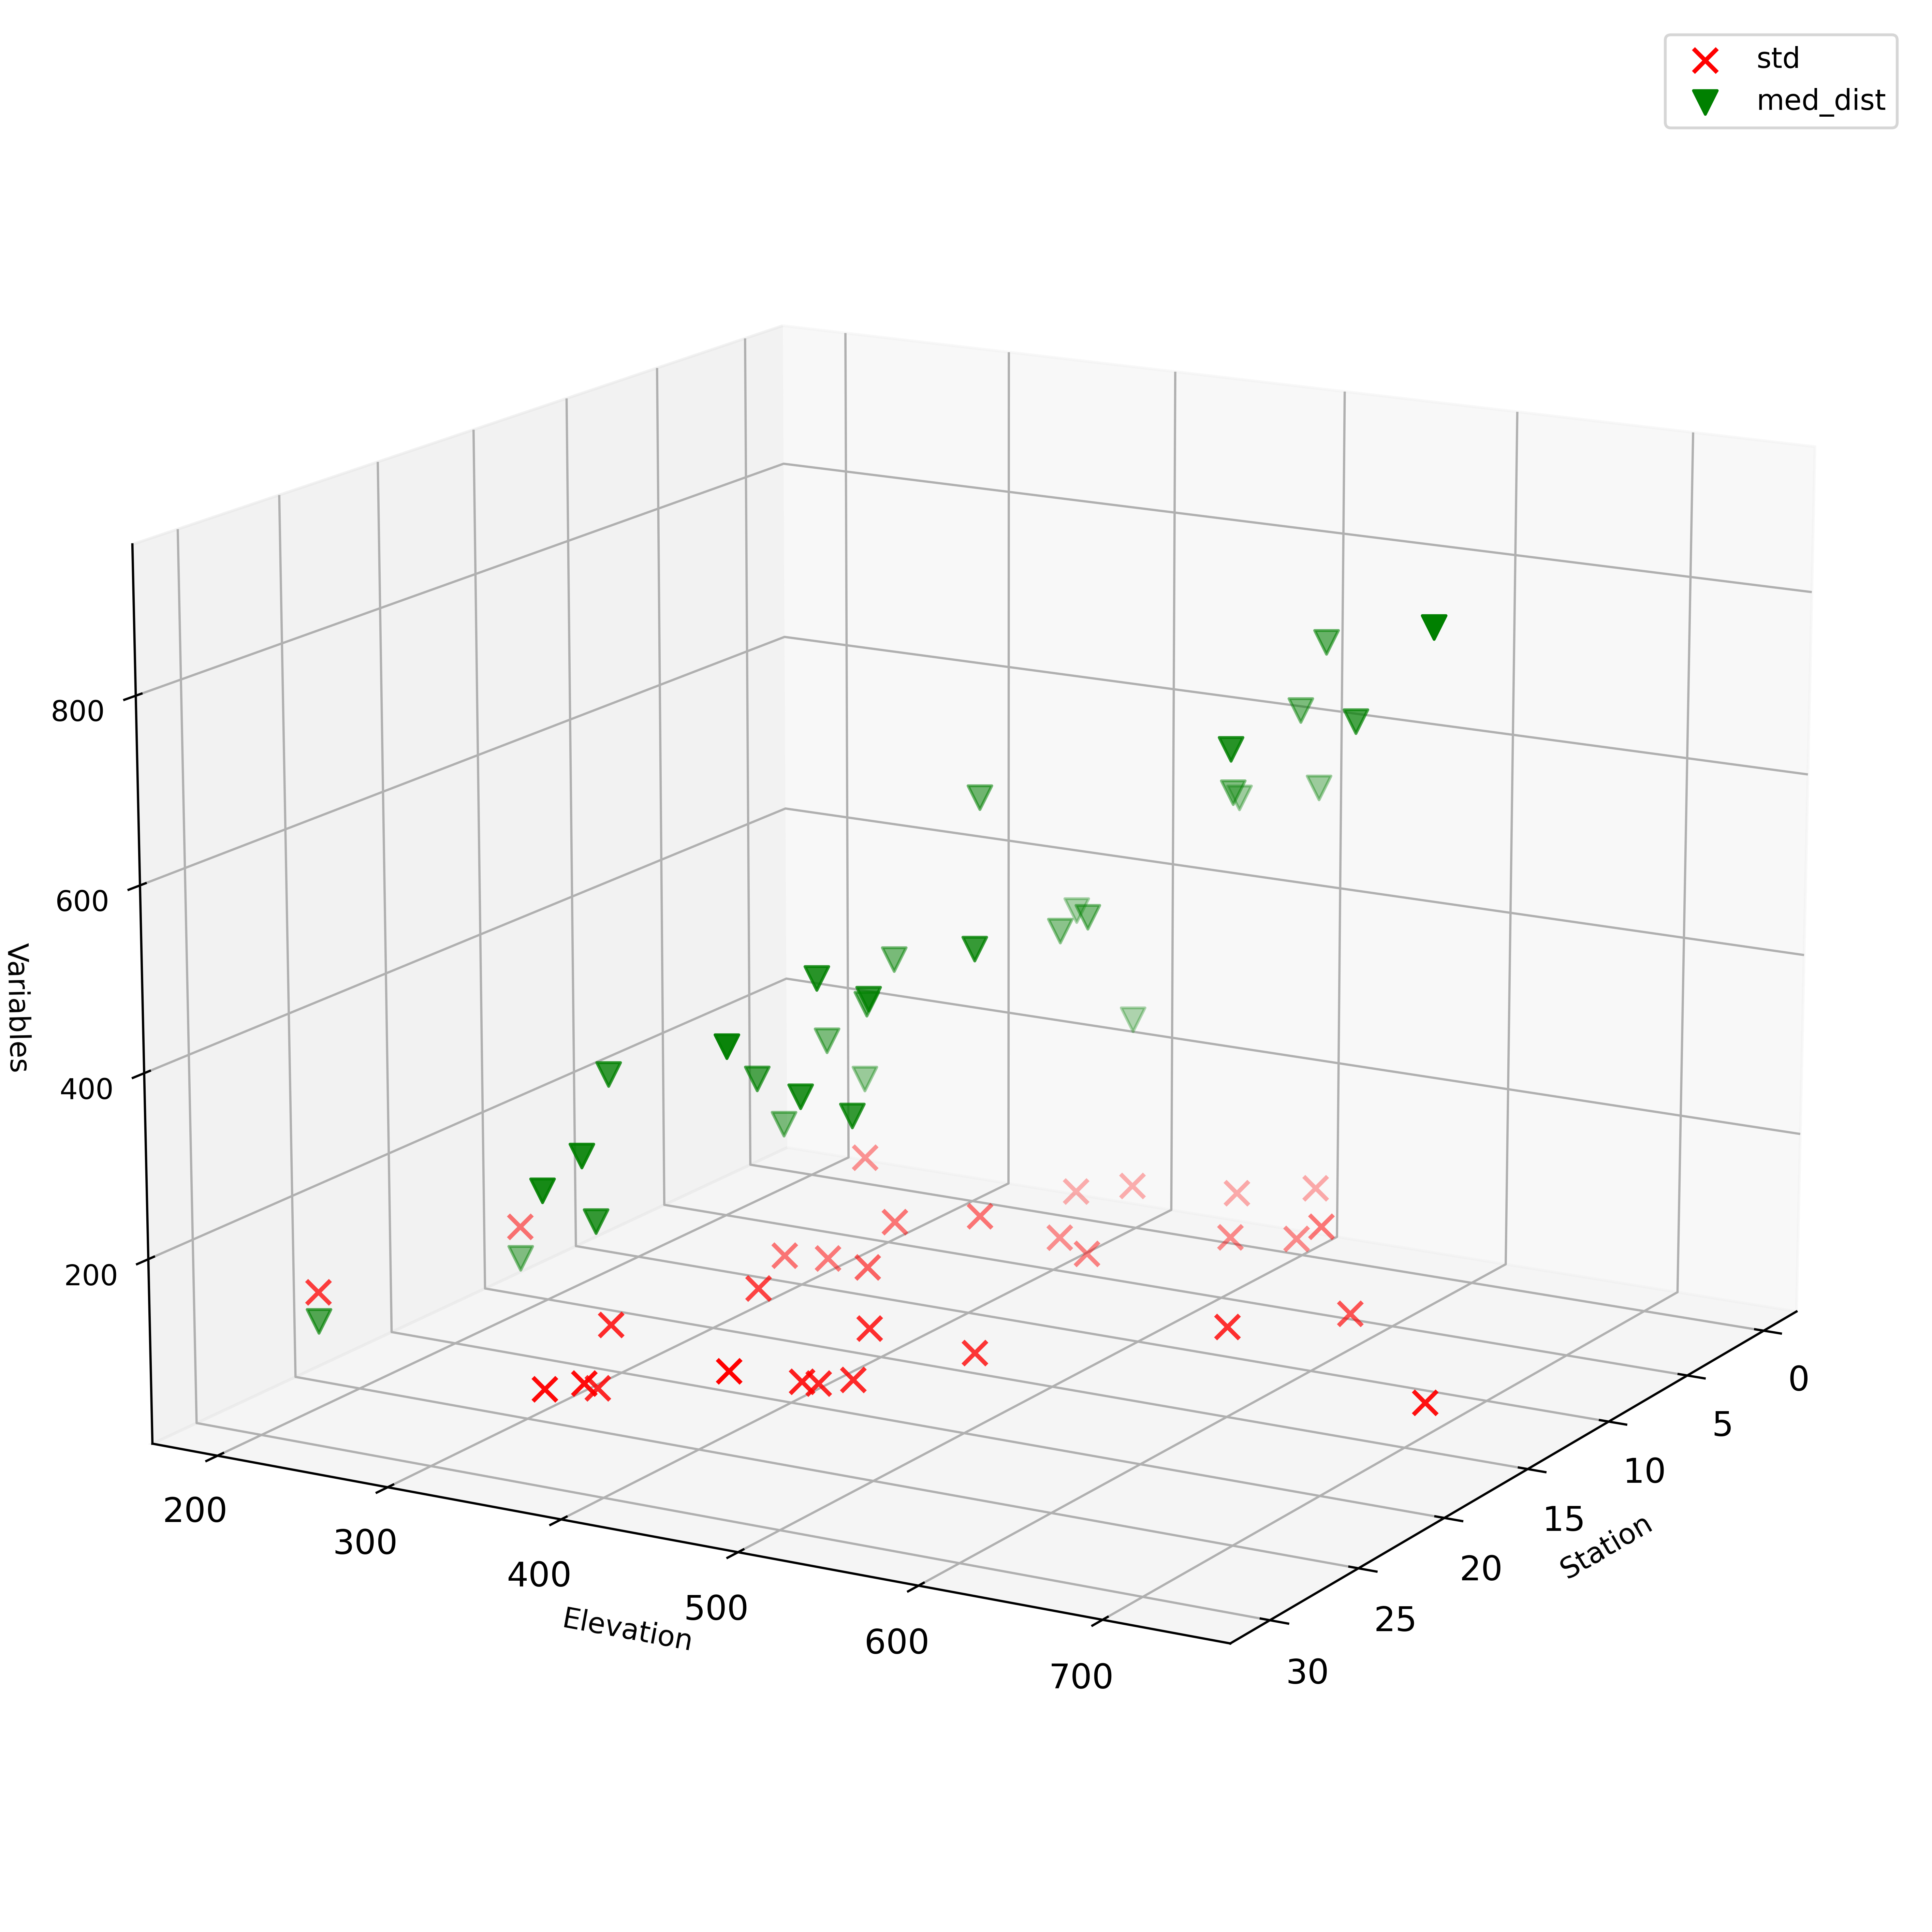

In [23]:
elev_plot(cluster_0)

In [24]:
stackplot(stack_df)

In [25]:
slope_plot(stack_df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/aevans/landtype/elevation/data/NY/slope/30km/ADDI_slope_30km.csv'

In [ ]:
# cluster 1
cluster_1 = df_cats.where(df_cats["Cluster"] == 1).dropna()
stack_df1 = stackbar_df(cluster_1)
stackplot(stack_df1)

In [ ]:
slope_plot(stack_df1)

In [ ]:
elev_plot(cluster_1)

In [ ]:
# cluster 2
cluster_2 = df_cats.where(df_cats["Cluster"] == 2).dropna()
stack_df2 = stackbar_df(cluster_2)
stackplot(stack_df2)

In [ ]:
slope_plot(stack_df2)

In [ ]:
elev_plot(cluster_2)

In [ ]:
# cluster 3
cluster_3 = df_cats.where(df_cats["Cluster"] == 3).dropna()
stack_df3 = stackbar_df(cluster_3)
stackplot(stack_df3)

In [ ]:
slope_plot(stack_df3)

In [ ]:
elev_plot(cluster_3)

In [ ]:
# cluster 4
cluster_4 = df_cats.where(df_cats["Cluster"] == 4).dropna()
stack_df4 = stackbar_df(cluster_4)
stackplot(stack_df4)

In [ ]:
slope_plot(stack_df4)

In [ ]:
elev_plot(cluster_4)

In [ ]:
# cluster 5
cluster_5 = df_cats.where(df_cats["Cluster"] == 5).dropna()
stack_df5 = stackbar_df(cluster_5)
stackplot(stack_df5)

In [ ]:
slope_plot(stack_df5)

In [ ]:
elev_plot(cluster_5)

In [ ]:
# cluster 6
cluster_6 = df_cats.where(df_cats["Cluster"] == 6).dropna()
stack_df6 = stackbar_df(cluster_6)
stackplot(stack_df6)

In [ ]:
slope_plot(stack_df6)

In [ ]:
elev_plot(cluster_6)

In [ ]:
# cluster 7
cluster_7 = df_cats.where(df_cats["Cluster"] == 7).dropna()
stack_df7 = stackbar_df(cluster_7)
stackplot(stack_df7)

In [ ]:
slope_plot(stack_df7)

In [ ]:
elev_plot(cluster_7)

# Let's Analyse Oklahoma

In [ ]:
df_cats_ok = pd.read_csv("/home/aevans/landtype/df_new_cats_ok.csv").drop(
    columns=[
        "Unnamed: 0.1",
        "Unnamed: 0",
        "color",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "31",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "25",
        "21_y",
        "23_y",
        "24_y",
        "27",
        "28",
        "22_y",
        "26",
        "Unnamed: 0_y",
    ]
)
df_cats_ok.keys()

In [ ]:
colors = ["black", "blue", "green", "red", "yellow", "plum"]

cats = [
    "Panhandle/High Plains",
    "Ouchita",
    "Chocsaw/Green",
    "Urban",
    "Central Plains",
    "Great Plains",
]

legend = [0, 1, 2, 3, 4, 5]

descripdict = {}
colordict = {}

for x, _ in enumerate(colors):
    descripdict.update({legend[x]: cats[x]})
    colordict.update({legend[x]: colors[x]})

patches = []
for i, _ in enumerate(colors):
    patch = mpatches.Patch(color=colors[i], label=cats[i])
    patches.append(patch)

In [ ]:
df_cats_ok["color"] = df_cats_ok["Cluster"].map(colordict)
df_cats_ok["cat"] = df_cats_ok["Cluster"].map(descripdict)

In [ ]:
plurality_plot(df_cats_ok)

In [ ]:
# cluster 0
clust_0 = df_cats_ok.where(df_cats_ok["Cluster"] == 0).dropna()
stack_df_ok = stackbar_df(clust_0)

In [ ]:
elev_plot(clust_0)

In [ ]:
stackplot(stack_df_ok)

In [ ]:
slope_plot_ok(stack_df_ok)

In [ ]:
# cluster 1
clust_1 = df_cats_ok.where(df_cats_ok["Cluster"] == 1).dropna()
stack_df_ok1 = stackbar_df(clust_1)

In [ ]:
elev_plot(clust_1)

In [ ]:
stackplot(stack_df_ok1)

In [ ]:
slope_plot_ok(stack_df_ok1)

In [ ]:
# cluster 2
clust_2 = df_cats_ok.where(df_cats_ok["Cluster"] == 2).dropna()
stack_df_ok2 = stackbar_df(clust_2)

In [ ]:
elev_plot(clust_2)

In [ ]:
stackplot(stack_df_ok2)

In [ ]:
slope_plot_ok(stack_df_ok2)

In [ ]:
# cluster 3
clust_3 = df_cats_ok.where(df_cats_ok["Cluster"] == 3).dropna()
stack_df_ok3 = stackbar_df(clust_3)

In [ ]:
elev_plot(clust_3)

In [ ]:
stackplot(stack_df_ok3)

In [ ]:
slope_plot_ok(stack_df_ok3)

In [ ]:
# cluster 4
clust_4 = df_cats_ok.where(df_cats_ok["Cluster"] == 4).dropna()
stack_df_ok4 = stackbar_df(clust_4)

In [ ]:
elev_plot(clust_4)

In [ ]:
stackplot(stack_df_ok4)

In [ ]:
slope_plot_ok(stack_df_ok4)

In [ ]:
# cluster 5
clust_5 = df_cats_ok.where(df_cats_ok["Cluster"] == 5).dropna()
stack_df_ok5 = stackbar_df(clust_5)

In [ ]:
elev_plot(clust_5)

In [ ]:
stackplot(stack_df_ok5)

In [ ]:
slope_plot_ok(stack_df_ok5)